In [16]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dat_dir = '../data/'
sub_dir = '../submit/'

## Part 1: Data Loading and Pre-processing

#### 1.1 Load the data

In [18]:
# Firstly we have a glance at the dataset
data = pd.read_csv(dat_dir + "data_train.csv")
data['row'], data['column'] = data['Id'].str.split('_', 1).str
data.head()

,Id,Prediction,row,column
0,r44_c1,4,r44,c1
1,r61_c1,3,r61,c1
2,r67_c1,4,r67,c1
3,r72_c1,3,r72,c1
4,r86_c1,5,r86,c1


In [19]:
data['Prediction'].median()

4.0

In [20]:
data['Prediction'].mean()

3.8572805008190647

In [21]:
data['row'] = data['row'].apply(lambda x: int(x.replace("r","")))
data['column'] = data['column'].apply(lambda x: int(x.replace("c","")))

In [22]:
data.max()

Id            r9_c999
Prediction          5
row             10000
column           1000
dtype: object

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


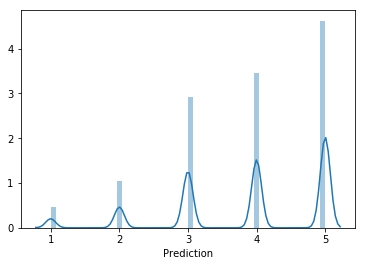

In [23]:
sns.distplot(data['Prediction'])

In [24]:
# We have 10,000 rows (users) and 1,000 columns (movies). However, we will take movies as rows and users as columns to build the ratings matrix for convenient 
from data_process import load_data

ratings = load_data(dat_dir + "data_train.csv")
print(np.shape(ratings))

number of items: 1000, number of users: 10000
(1000, 10000)


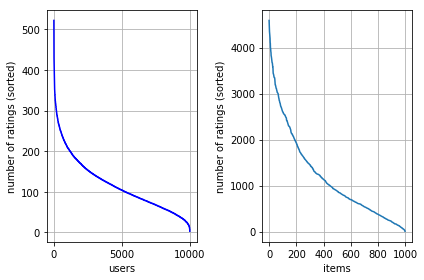

min # of items per user = 3, min # of users per item = 8.


In [26]:
# Plot the number of ratings per movie and user
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))
# Since only a few users rated a small amount of movies and the same as the movies, we take all the users and movies into account.

#### 1.2 Split the data into a training and test set

In [28]:
from data_process import split_data

valid_ratings, train, test = split_data(ratings, p_test=0.1)

the shape of original ratings. (# of row, # of col): (1000, 10000)
the shape of valid ratings. (# of row, # of col): (1000, 10000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1068598
Total number of nonzero elements in test data:108354


## Part 2: Learn the Matrix Factorization using SGD

##### A. grid search using Surprise

We use the library of Surprise to grid search hyperparameters with 5-folds cross-validation in implement_surprise.py. 

Best parameters provided by surprise: {'n_epochs': 30, 'n_factors': 10, 'lr_all': 0.005, 'reg_pu': 0.1, 'reg_qi': 0.01}. Here, 'n_factors' is the number of latent features, 'lr_all' is the learning rate, 'reg_pu' is the regularizer for user and 'reg_qi' is the regularizer for item.

The optimized model has pretty good performance on the test dataset with rmse < 0.9, but the optimized model performs not well when we submitted for a final score, which gave rmse of 1.055  as a final result. Therefore, we reasoned that there was somehow overfitting even that we have added regularizers to the model. This is also the motivation that we did the grid search by ourselves.

##### B. grid search without Surprise

Firstly, we set $\gamma$, the learning rate, to be 0.025 by our previous experience. Then, we use grid search to find the best parameters which are the number of latent features $K$, the regularizer for user $\lambda_{u}$ and the regularizer for item $\lambda_{i}$

In gs_reg_MF.py, we do the grid search and save the results into a .npy files. 

## Part 3: Build the Regularized Model of Matrix Factorization

In [29]:
from SGD_helpers import  init_MF, matrix_factorization_SGD
# best parameters 
best_gamma = 0.025
best_lambda_u = 0.1
best_lambda_i = 0.01
K = 20
num_epochs = 50

user_init, item_init = init_MF(ratings, K)
item_feats_SGD, user_feats_SGD, rmse = matrix_factorization_SGD(ratings, test, best_gamma, K, best_lambda_u, best_lambda_i, num_epochs,
                                                                    user_init, item_init)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0602437466735075.
iter: 5, RMSE on training set: 0.9878757873912704.
iter: 10, RMSE on training set: 0.9470166986415138.
iter: 15, RMSE on training set: 0.9279880131409022.
iter: 20, RMSE on training set: 0.9211889331463198.
iter: 25, RMSE on training set: 0.9187209640351999.
iter: 30, RMSE on training set: 0.9177720047654193.
iter: 35, RMSE on training set: 0.9173967721402485.
iter: 40, RMSE on training set: 0.9172454942457577.
iter: 45, RMSE on training set: 0.9171847488622655.
iter: 49, RMSE on training set: 0.9171636213911376.
RMSE on test data: 0.9167276296366479.


In [16]:
from MF_helpers import predict_no_bias
# save features
np.save(dat_dir + 'item_feats_SGD.npy', item_feats_SGD)
np.save(dat_dir + 'user_feats_SGD.npy', user_feats_SGD)

# load features
# item_feats_SGD = np.load(dat_dir + 'item_feats_SGD.npy')
# user_feats_SGD = np.load(dat_dir + 'user_feats_SGD.npy')
predictions =  predict_no_bias(item_feats_SGD, user_feats_SGD)

## Part 4: Build the Biased Model of Matrix Factorization

#### 3.1: Overview

As the figure of ratings distribution shown in part 1, the dominant ratings range from 3to 5. One possible reason is that most users are tended to give a higher rating. Therefore, we considered building a biasedmatrix factorization model. 

E:\anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


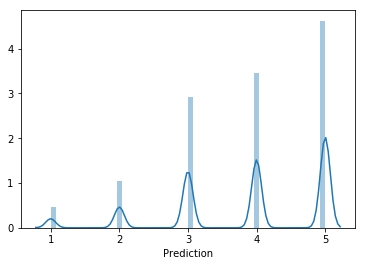

In [15]:
sns.distplot(data['Prediction'])

To better model the differences from users to users and from items to items, we want to identify the portion of these values which the biases could explain. The biases are expressed as $$b_{i,u} = \mu + b_{u} + b_{i}$$

And we use following formula to build the biased model of matrix factorization:
$$min_{W,Z}{\mathbb{L}(W,Z)}:=\frac{1}{2}\sum_{(i,u)\in\Omega}[x_{i,u} - (WZ^T)_{i,u}]^2 \\+ \lambda_{w}({\lvert\lvert W \rvert\rvert_F^2 + b_i^2}) + \lambda_{z}({\lvert\lvert Z \rvert\rvert_F^2 + b_u^2})$$

In [26]:
from MF_helpers import get_bias_train, get_bias_test

In [27]:
bias_train, total_bias, bias_u_train, bias_i_train = get_bias_train(train) #ratings for final submissions
bias_test = get_bias_test(test, total_bias, bias_u_train, bias_i_train)

#### 3.2: Finding parameters for SGD by grid search

To find the best parameters, we follow the same steps in part 2 to do the grid search, in the gs_biased_MF.py. And we save the results into several .npy files.

#### 3.3: Running SGD with the best parameters

In [28]:
# define parameters
gamma = 0.025
K = 50
lambda_user = 0.1 
lambda_item = 0.01
num_epochs = 50
user_init, item_init = init_MF(bias_train, K)

item_features_bias, user_features_bias, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_user, lambda_item, num_epochs, user_init, item_init)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0148365823565952.
iter: 5, RMSE on training set: 0.880109842486806.
iter: 10, RMSE on training set: 0.8252870439456371.
iter: 15, RMSE on training set: 0.8065028849906606.
iter: 20, RMSE on training set: 0.7996947945129235.
iter: 25, RMSE on training set: 0.7970885996782676.
iter: 30, RMSE on training set: 0.7960619899593706.
iter: 35, RMSE on training set: 0.7956524401101966.
iter: 40, RMSE on training set: 0.795488334459468.
iter: 45, RMSE on training set: 0.7954224582089823.
iter: 49, RMSE on training set: 0.7953995516544337.
RMSE on test data: 1.029180515629877.


In [25]:
# save features
np.save(dat_dir + 'item_features_bias.npy', item_features_bias)
np.save(dat_dir + 'user_features_bias.npy', user_features_bias)

In [16]:
import pickle
tempt_dir = './'
with open(tempt_dir + 'user_features_bias.pk','rb') as f:
    user_features_bias = pickle.load(f)
    
with open(tempt_dir + 'item_features_bias.pk','rb') as f:
    item_features_bias = pickle.load(f)

Compute the predictions:

In [27]:
from MF_helpers import predict_with_bias, predict_no_bias

predictions = predict_with_bias(item_features_bias, user_features_bias, total_bias, bias_u_train, bias_i_train)

## Part 5: Submission

We finally decide to use the prediction without bias.

In [26]:
from data_process import create_submission
create_submission(predictions)